# Exploração e tratamento inicial dos dados

**Objetivo:**
1. Carregar os dados;
2. Selecionar as colunas que serão lidas;
3. Fazer uma amostragem aleatória de 800.000 dados (~20% do dataset);
4. Salvar em um novo ``.csv`` que seja mais leve
5. Fazer uma análise exploratória de cada feature;
6. Transformação dos dados:  
   a. Aglutinar features;  
   b. Diminuir número de categorias;  
   c. Dados numéricos -> categorizar em faixas;  


## Seleção de variáveis e amostragem dos dados

In [ ]:
""""
GERA O ARQUIVO SAMPLE, NÃO RODAR SE O ARQUIVO JÁ ESTIVER CRIADO
"""

# import pandas as pd
# import numpy as np
# from pathlib import Path

# # Configurações
# DATA_PATH = Path().resolve() / 'data'
# ARQUIVO_ORIGEM_PATH = DATA_PATH / 'raw' / 'microdados_enem_2023.csv'
# ARQUIVO_DESTINO_PATH = DATA_PATH / 'raw' / 'microdados_enem_2023_sample.csv'

# colunas_desejadas = [
#     'NU_INSCRICAO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
#     'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
#     'IN_TREINEIRO', 'CO_MUNICIPIO_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC',
#     'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH',
#     'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
#     'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA',
#     'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
#     'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q025'
# ]

# # Parâmetros
# tamanho_amostra_final = 800_000
# tamanho_arquivo_total = 4_000_000  # Aproximadamente
# frac_amostragem = tamanho_amostra_final / tamanho_arquivo_total

# # Leitura em chunks
# chunk_size = 500_000
# amostras = []

# for chunk in pd.read_csv(ARQUIVO_ORIGEM_PATH, usecols=colunas_desejadas, chunksize=chunk_size, sep=';', encoding='latin1'):
#     amostra_chunk = chunk.sample(frac=frac_amostragem, random_state=553)
#     amostras.append(amostra_chunk)

# # Junta tudo
# # amostra_final = pd.concat(amostras).sample(n=tamanho_amostra_final, random_state=42) # resultado da LLM
# amostra_final = pd.concat(amostras)

# # Salva no CSV
# amostra_final.to_csv(ARQUIVO_DESTINO_PATH, index=False)

# print(f"Amostra salva em {ARQUIVO_DESTINO_PATH}")

## Leitura eficiente do dataframe amostrado

In [235]:
import pandas as pd
import numpy as np
from pathlib import Path

# Configurações
DATA_PATH = Path().resolve() / 'data'
ARQUIVO_AMOSTRA_PATH = DATA_PATH / 'raw' / 'microdados_enem_2023_sample.csv'

# Definição dos tipos
colunas_float = [
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
    'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'
]

colunas_string = [
    'NU_INSCRICAO', 'CO_MUNICIPIO_ESC', 'CO_MUNICIPIO_PROVA'
]

# Captura os nomes das colunas
colunas = pd.read_csv(ARQUIVO_AMOSTRA_PATH, nrows=0, encoding='latin1').columns.tolist()

# Preparar o dicionário de tipos
dtypes = {}
for col in colunas:
    if col in colunas_float:
        dtypes[col] = 'float32'
    elif col in colunas_string:
        dtypes[col] = 'string'
    else:
        dtypes[col] = 'category'

# Leitura com tipos otimizados
df = pd.read_csv(ARQUIVO_AMOSTRA_PATH, dtype=dtypes, encoding='latin1')

# Informações para conferência
print("="*40)
print(f"Memória usada: {df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
print(f"Quantidade de colunas: {df.shape[1]}")
print(f"Quantidade de linhas: {df.shape[0]}")
print("="*40)

# Tipos de dados
print("\nTipos de dados por coluna:")
print(df.dtypes)

Memória usada: 180.46 MB
Quantidade de colunas: 40
Quantidade de linhas: 786791

Tipos de dados por coluna:
NU_INSCRICAO              string[python]
TP_FAIXA_ETARIA                 category
TP_SEXO                         category
TP_ESTADO_CIVIL                 category
TP_COR_RACA                     category
TP_NACIONALIDADE                category
TP_ST_CONCLUSAO                 category
TP_ANO_CONCLUIU                 category
TP_ESCOLA                       category
TP_ENSINO                       category
IN_TREINEIRO                    category
CO_MUNICIPIO_ESC          string[python]
TP_DEPENDENCIA_ADM_ESC          category
TP_LOCALIZACAO_ESC              category
TP_SIT_FUNC_ESC                 category
CO_MUNICIPIO_PROVA        string[python]
TP_PRESENCA_CN                  category
TP_PRESENCA_CH                  category
TP_PRESENCA_LC                  category
TP_PRESENCA_MT                  category
CO_PROVA_CN                     category
CO_PROVA_CH                    

## Variáveis categóricas

### Análise de dados nulos

In [220]:
# Checagem de valores nulos
print("\nValores nulos por coluna:")
nulos = df.isnull().sum()
percentual_nulos = (nulos / len(df)) * 100

# Criando um dataframe com os valores absolutos e percentuais
df_nulos = pd.DataFrame({
    'Valores Nulos': nulos,
    'Percentual Nulos (%)': percentual_nulos
})

# Exibindo o dataframe de nulos
print(df_nulos)


Valores nulos por coluna:
                        Valores Nulos  Percentual Nulos (%)
NU_INSCRICAO                        0              0.000000
TP_FAIXA_ETARIA                     0              0.000000
TP_SEXO                             0              0.000000
TP_ESTADO_CIVIL                     0              0.000000
TP_COR_RACA                         0              0.000000
TP_NACIONALIDADE                    0              0.000000
TP_ST_CONCLUSAO                     0              0.000000
TP_ANO_CONCLUIU                     0              0.000000
TP_ESCOLA                           0              0.000000
TP_ENSINO                      519042             65.969489
IN_TREINEIRO                        0              0.000000
CO_MUNICIPIO_ESC               594910             75.612202
TP_DEPENDENCIA_ADM_ESC         594910             75.612202
TP_LOCALIZACAO_ESC             594910             75.612202
TP_SIT_FUNC_ESC                594910             75.612202
CO_MUNICIPIO_

Dessa análise, já decidimos descartar os dados:
- ``CO_MUNICIPIO_ESC``                         
- ``TP_DEPENDENCIA_ADM_ESC``                   
- ``TP_LOCALIZACAO_ESC``                       
- ``TP_SIT_FUNC_ESC``
porque 75% dos seus valores são nulos                          

### Dados demográficos

C:\Users\isabe\AppData\Local\Temp\ipykernel_11348\867491838.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels, rotation=30, ha='right')
C:\Users\isabe\AppData\Local\Temp\ipykernel_11348\867491838.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels, rotation=30, ha='right')
C:\Users\isabe\AppData\Local\Temp\ipykernel_11348\867491838.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels, rotation=30, ha='right')
C:\Users\isabe\AppData\Local\Temp\ipykernel_11348\867491838.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels, rotation=

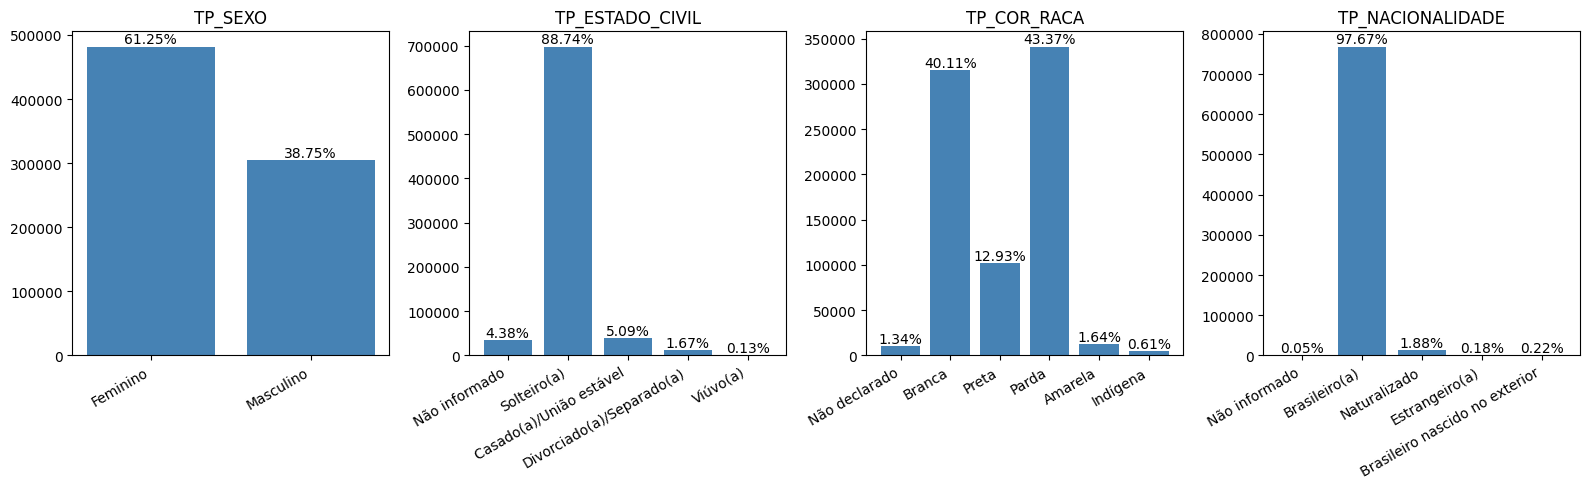

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {
    'TP_SEXO': {'M': 'Masculino', 'F': 'Feminino'},
    'TP_ESTADO_CIVIL': {
        '0': 'Não informado',
        '1': 'Solteiro(a)',
        '2': 'Casado(a)/União estável',
        '3': 'Divorciado(a)/Separado(a)',
        '4': 'Viúvo(a)'
    },
    'TP_COR_RACA': {
        '0': 'Não declarado',
        '1': 'Branca',
        '2': 'Preta',
        '3': 'Parda',
        '4': 'Amarela',
        '5': 'Indígena',
        '6': 'Sem info'
    },
    'TP_NACIONALIDADE': {
        '0': 'Não informado',
        '1': 'Brasileiro(a)',
        '2': 'Naturalizado',
        '3': 'Estrangeiro(a)',
        '4': 'Brasileiro nascido no exterior'
    }
}

# Colunas a serem visualizadas
colunas_plot = ['TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE']

# Criar subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, col in enumerate(colunas_plot):
    # Frequência absoluta
    freq_abs = df[col].value_counts().sort_index()
    # Frequência relativa em %
    freq_rel = (freq_abs / len(df)) * 100
    labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

    axes[i].bar(labels, freq_abs.values, color='steelblue')
    axes[i].set_title(f'{col}')

    axes[i].set_xticklabels(labels, rotation=30, ha='right')
    
    # Adiciona os valores relativos em % em cima de cada barra
    for j, val in enumerate(freq_abs.values):
        axes[i].text(j, val + 50, f'{freq_rel.values[j]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Dados de faixa etária

In [ ]:
import pandas as plt
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {'TP_FAIXA_ETARIA' : {
    '1': "Menor de 17 anos",
    '2': "17 anos",
    '3': "18 anos",
    '4': "19 anos",
    '5': "20 anos",
    '6': "21 anos",
    '7': "22 anos",
    '8': "23 anos",
    '9': "24 anos",
    '10': "25 anos",
    '11': "26–30 anos",
    '12': "31–35 anos",
    '13': "36–40 anos",
    '14': "41–45 anos",
    '15': "46–50 anos",
    '16': "51–55 anos",
    '17': "56–60 anos",
    '18': "61–65 anos",
    '19': "66–70 anos",
    '20': "Maior de 70 anos"
    }
}

# Colunas a serem visualizadas
colunas_plot = ['TP_FAIXA_ETARIA']
col = 'TP_FAIXA_ETARIA'

# Criar subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Frequência absoluta
freq_abs = df[col].value_counts(dropna=False).sort_index(key=lambda x: x.astype(float))
# Frequência relativa em %
freq_rel = (freq_abs / len(df)) * 100

labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

ax.bar(labels, freq_abs.values, color='steelblue')
ax.set_title(f'{col}')

ax.set_xticklabels(labels, rotation=45, ha='right')

# Adiciona os valores relativos em % em cima de cada barra
for j, val in enumerate(freq_abs.values):
    ax.text(j, val + 50, f'{freq_rel.values[j]:.2f}%', ha='center', va='bottom', fontsize=10, color='black', rotation=30)

plt.tight_layout()
plt.show()

Decidimos não utilizar os dados de "Faixa etária" porque nos dão uma informação muito parecida com aquela dos "Dados de conclusão do Ensino Médio". Como será mostrado a seguir, esses dados podem ser mais precisos ao nos dizer sobre a "experiência escolar" do candidato no contexto da realização da prova do ENEM.

### Dados de conclusão do Ensino Médio

Observando os resultados abaixo, percebemos que todos os candidatos que marcaram "Não informado" na variável ``TP_ANO_CONCLUIU`` podem ser incluídos em uma das categorias de ``TP_ST_CONCLUSAO``. Então, decidimos unir essas duas variaveis na variável ``TP_CONCLUSAO``.

In [ ]:
print("\nAno em que concluiu:")

tp_escola = df['TP_ANO_CONCLUIU'].value_counts(dropna=False).sort_index(key=lambda x: x.astype(int))
tp_escola_pct = df['TP_ANO_CONCLUIU'].value_counts(normalize=True, dropna=False).sort_index(key=lambda x: x.astype(int)) * 100

resultado = pd.DataFrame({
    'Frequência': tp_escola[tp_escola.index],
    'Percentual (%)': tp_escola_pct[tp_escola_pct.index].round(2)
})

print(resultado)

print("\nSituação de conclusão:")

st_conclusao = df['TP_ST_CONCLUSAO'].value_counts(dropna=False).sort_index(key=lambda x: x.astype(int))
st_conclusao_pct = df['TP_ST_CONCLUSAO'].value_counts(normalize=True, dropna=False).sort_index(key=lambda x: x.astype(int)) * 100

resultado = pd.DataFrame({
    'Frequência': st_conclusao,
    'Percentual (%)': st_conclusao_pct.round(2)
})

print(resultado)


In [ ]:
print("\nDos que já concluíram, foi em qual ano:")
df[df['TP_ST_CONCLUSAO'] == '1'].TP_ANO_CONCLUIU.value_counts(dropna=False).sort_index(key=lambda x: x.astype(int))

Ainda, como a quantidade de candidatos que já concluíram o Ensino Médio decresce à medida que se afastam do ano de 2023, decidimos aglutinar algumas dessas categorias.

In [ ]:
print("\nAno em que concluiu:")

tp_escola = df['TP_ANO_CONCLUIU'].value_counts(dropna=False).sort_index(key=lambda x: x.astype(int))
tp_escola_pct = df['TP_ANO_CONCLUIU'].value_counts(normalize=True, dropna=False).sort_index(key=lambda x: x.astype(int)) * 100

resultado = pd.DataFrame({
    'Frequência': tp_escola,
    'Percentual (%)': tp_escola_pct.round(2)
})

print(resultado)

Assim, é gerada uma nova variável ``TP_CONCLUSAO`` que une as informações dessas duas variáveis. Mais informações na seção 'Transformações' do notebook.
- 1: EM concluído mas sem ano
- 2: EM será concluído em 2023
- 3: EM será concluído após 2023
- 4: EM não cursado
- 5: EM concluído em 2022
- 6: EM concluído entre 2021 e 2018
- 7: EM concluído entre 2017 e 2007
- 8: EM concluído antes de 2007

### Dados da escola do Ensino Médio

In [ ]:
df['TP_ENSINO'].value_counts(dropna=False)

In [ ]:
import pandas as plt
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {
    'TP_ESCOLA': {'1': 'Não Respondeu', '2': 'Pública', '3': 'Privada'},
    'IN_TREINEIRO': {'1': 'Sim', '0': 'Não'},
    'TP_ENSINO':{'1.0': 'Regular', '2.0': 'Especial'} 
}

# Colunas a serem visualizadas
colunas_plot = ['TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO']

# Criar subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, col in enumerate(colunas_plot):
    # Frequência absoluta
    freq_abs = df[col].value_counts(dropna=False).sort_index()
    # Frequência relativa em %
    freq_rel = (freq_abs / len(df)) * 100
    labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

    axes[i].bar(labels, freq_abs.values, color='steelblue')
    axes[i].set_title(f'{col}')

    axes[i].set_xticklabels(labels, rotation=30, ha='right')
    
    # Adiciona os valores relativos em % em cima de cada barra
    for j, val in enumerate(freq_abs.values):
        axes[i].text(j, val + 50, f'{freq_rel.values[j]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

A partir dos dados da escola em que o candidato cursou o Ensino Médio, podemos perceber que a maior parte dos dados é inexistente. Todavia, manteremos essas variáveis na modelagem pois pode ser possível encontrar padrões interessantes para os usuários que não responderam. 

Como há uma quantidade muito pequena de dados com ``TP_ENSINO`` da categoria 'Especial', não vamos considerar essa variável no algoritmo de mineração de padrões

### Dados do município de aplicação

Os dados da escola onde o candidato tem muitos valores nulos como pode ser visto na seção "Dados nulos (geral)", por isso não serão usados na modelagem.

Uma proxy para localizaão será a região onde o candidato realizou a prova, que pode ser extraída da variável ``CO_MUNICIPIO_PROVA``.

In [ ]:
df['CO_MUNICIPIO_PROVA'].head(5)

Sabemos que o primeiro dígito corresponde à região, mas não sabemos qual é qual. Para isso investigaremos uma parte do arquivo original pra descobrir qual dígito corresponde a qual região do Brasil.

In [ ]:
DATA_PATH = Path().resolve() / 'data'
ARQUIVO_ORIGEM_PATH = DATA_PATH / 'raw' / 'microdados_enem_2023.csv'
regiao = pd.read_csv(ARQUIVO_ORIGEM_PATH, encoding='latin1', nrows=1000, usecols=['CO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA'],
                     delimiter=';')
regiao.groupby(by='CO_UF_PROVA').first()


Portanto, nosso mapeamento é:
- 1: Norte
- 2: Nordeste
- 3: Sudeste
- 4: Sul
- 5: Centro-Oeste

In [ ]:
df['REGIAO'] = df['CO_MUNICIPIO_PROVA'].apply(lambda x: x[0])
df['REGIAO'] = df['REGIAO'].astype('category')
df['REGIAO'].value_counts(normalize=True, dropna=False)

Portanto, temos dados para todas as regiões do Brasil, e da pra ver que a maior parte dos candidatos é do Nordeste, seguidos pelo Sudeste.

### Dados de presença nas provas objetivas

A presença nas provas pode ser resumida a:
- Presença no primeiro dia: CH e LC
- Presença no segundo dia: CN e MT

Para mostrar que as variáveis ``TP_PRESENCA_CH`` e ``TP_PRESENCA_LC`` são correspondentes, e ``TP_PRESENCA_CN`` e ``TP_PRESENCA_MT`` também, plotamos uma matriz de coocorrência

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tabelas de coocorrência
cont_mt_cn = pd.crosstab(df['TP_PRESENCA_MT'], df['TP_PRESENCA_CN'])
cont_ch_lc = pd.crosstab(df['TP_PRESENCA_CH'], df['TP_PRESENCA_LC'])

# Criar a figura com subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 5x10 total (altura x largura)

# Heatmap 1: MT vs CN
axes[0].imshow(cont_mt_cn, cmap='Blues', aspect='auto')
axes[0].set_title('TP_PRESENCA_MT x TP_PRESENCA_CN')
axes[0].set_xlabel('TP_PRESENCA_CN')
axes[0].set_ylabel('TP_PRESENCA_MT')
axes[0].set_xticks(range(len(cont_mt_cn.columns)))
axes[0].set_xticklabels(cont_mt_cn.columns)
axes[0].set_yticks(range(len(cont_mt_cn.index)))
axes[0].set_yticklabels(cont_mt_cn.index)

# Adiciona valores no heatmap 1
for i in range(cont_mt_cn.shape[0]):
    for j in range(cont_mt_cn.shape[1]):
        axes[0].text(j, i, cont_mt_cn.values[i, j], ha='center', va='center', color='black')

# Heatmap 2: CH vs LC
axes[1].imshow(cont_ch_lc, cmap='Greens', aspect='auto')
axes[1].set_title('TP_PRESENCA_CH x TP_PRESENCA_LC')
axes[1].set_xlabel('TP_PRESENCA_LC')
axes[1].set_ylabel('TP_PRESENCA_CH')
axes[1].set_xticks(range(len(cont_ch_lc.columns)))
axes[1].set_xticklabels(cont_ch_lc.columns)
axes[1].set_yticks(range(len(cont_ch_lc.index)))
axes[1].set_yticklabels(cont_ch_lc.index)

# Adiciona valores no heatmap 2
for i in range(cont_ch_lc.shape[0]):
    for j in range(cont_ch_lc.shape[1]):
        axes[1].text(j, i, cont_ch_lc.values[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


### Dados do tipo de língua e do status da redação

Apenas para entender a quantidade de pessoas que escolheu inglês ou espanhol, e também quantas pessoas tiveram alguma intercorrência na redação.

In [ ]:
import pandas as plt
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {
    'TP_LINGUA': {'0': 'Inglês', '1': 'Espanhol'},
    'TP_STATUS_REDACAO': {'1.0': 'Sem problemas',
        '2.0': 'Anulada',
        '3.0': 'Cópia Texto Motivador',
        '4.0': 'Em Branco',
        '6.0': 'Fuga ao tema',
        '7.0': 'Não atendimento ao tipo textual',
        '8.0': 'Texto insuficiente',
        '9.0': 'Parte desconectada' 
    }
}

# Colunas a serem visualizadas
colunas_plot = ['TP_LINGUA', 'TP_STATUS_REDACAO']

# Criar subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(colunas_plot):
    # Frequência absoluta
    freq_abs = df[col].value_counts(dropna=False).sort_index()
    # Frequência relativa em %
    freq_rel = (freq_abs / len(df)) * 100
    labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

    axes[i].bar(labels, freq_abs.values, color='steelblue')
    axes[i].set_title(f'{col}')

    axes[i].set_xticklabels(labels, rotation=30, ha='right')
    
    # Adiciona os valores relativos em % em cima de cada barra
    for j, val in enumerate(freq_abs.values):
        axes[i].text(j, val + 50, f'{freq_rel.values[j]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

Ainda, a quantidade de redações com tipo ``nan`` é a quantidade de ausências + eliminados do dia 1. Ou seja, os valores nulos em ``TP_STATUS_REDACAO`` correspondem aos candidatos ausentes ou eleiminados da redação.

In [ ]:
ausencias_dia1 = df['TP_PRESENCA_CH'][df['TP_PRESENCA_CH'] != '1'].count()
redacoes_nulas = df['TP_STATUS_REDACAO'].isna().sum()

print(f'Ausentes e eliminados do dia 1: {ausencias_dia1}')
print(f'Valores Nan em TIPO_STATUS_REDACAO: {redacoes_nulas}')

### Dados dos tipos de prova

Da cor do caderno de provas, pode-se inferir se a prova tem alguma adaptação. 
- Sabemos, a priori, que os cadernos de CN e MT são iguais, bem como os cadernos de CH e LC, por isso não plotaremos todos.
- Sabemos, também, que valores nulos nos códigos de caderno correspondem a candidatos ausentes naquele dia.

In [ ]:
import pandas as plt
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {
    'CO_PROVA_LC' : {
        '1201.0': "Azul",
        '1202.0': "Amarela",
        '1203.0': "Rosa",
        '1204.0': "Branca",
        '1205.0': "Rosa - Ampliada",
        '1206.0': "Rosa - Superampliada",
        '1207.0': "Laranja - Braile",
        '1208.0': "Laranja - Adaptada Ledor",
        '1209.0': "Verde - Videoprova - Libras",
        '1281.0': "Azul (Reaplicação)",
        '1282.0': "Amarela (Reaplicação)",
        '1283.0': "Rosa (Reaplicação)",
        '1284.0': "Branca (Reaplicação)"
    },
    'CO_PROVA_CN': {
        '1221.0': "Azul",
        '1222.0': "Amarela",
        '1223.0': "Rosa",
        '1224.0': "Cinza",
        '1225.0': "Rosa - Ampliada",
        '1226.0': "Rosa - Superampliada",
        '1227.0': "Laranja - Braile",
        '1228.0': "Laranja - Adaptada Ledor",
        '1229.0': "Verde - Videoprova - Libras",
        '1301.0': "Azul (Reaplicação)",
        '1302.0': "Amarela (Reaplicação)",
        '1303.0': "Cinza (Reaplicação)",
        '1304.0': "Rosa (Reaplicação)"
    }
}

# Colunas a serem visualizadas
colunas_plot = ['CO_PROVA_LC', 'CO_PROVA_CN']

# Criar subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, col in enumerate(colunas_plot):
    # Frequência absoluta
    freq_abs = df[col].value_counts(dropna=False).sort_index()
    # Frequência relativa em %
    # freq_rel = (freq_abs / len(df)) * 100
    labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

    axes[i].bar(labels, freq_abs.values, color='steelblue')
    axes[i].set_title(f'{col}')

    axes[i].set_xticklabels(labels, rotation=30, ha='right')
    
    # Adiciona os valores relativos em % em cima de cada barra
    for j, val in enumerate(freq_abs.values):
        axes[i].text(j, val + 50, f'{freq_abs.values[j]}', ha='center', va='bottom', fontsize=10, color='black', rotation=45)

plt.tight_layout()
plt.show()

Apesar de haver poucos valores pra provas adaptadas, extrair essa informação pode ser interessante para encontrar algum padrão.

Pra confirmar que os cadernos são iguais para CN e MT, CH e LC, fazemos um crosstab. Essa pequena diferença vista em CH e LC se dá pelo fato de os códigos serem trocados para as provas "Branca" e "Rosa", e "Branca (Reaplicação)" e "Rosa (Reaplicação)".

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tabelas de coocorrência
cont_mt_cn = pd.crosstab(df['CO_PROVA_MT'], df['CO_PROVA_CN'])
cont_ch_lc = pd.crosstab(df['CO_PROVA_CH'], df['CO_PROVA_LC'])

# Criar a figura com subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 5x10 total (altura x largura)

# Heatmap 1: MT vs CN
axes[0].imshow(cont_mt_cn, cmap='Blues', aspect='auto')
axes[0].set_title('CO_PROVA_MT x CO_PROVA_CN')
axes[0].set_xlabel('CO_PROVA_CN')
axes[0].set_ylabel('CO_PROVA_MT')
axes[0].set_xticks(range(len(cont_mt_cn.columns)))
axes[0].set_xticklabels(cont_mt_cn.columns)
axes[0].set_yticks(range(len(cont_mt_cn.index)))
axes[0].set_yticklabels(cont_mt_cn.index)

# Adiciona valores no heatmap 1
for i in range(cont_mt_cn.shape[0]):
    for j in range(cont_mt_cn.shape[1]):
        axes[0].text(j, i, cont_mt_cn.values[i, j], ha='center', va='center', color='black')

# Heatmap 2: CH vs LC
axes[1].imshow(cont_ch_lc, cmap='Greens', aspect='auto')
axes[1].set_title('CO_PROVA_CH x CO_PROVA_LC')
axes[1].set_xlabel('CO_PROVA_LC')
axes[1].set_ylabel('CO_PROVA_CH')
axes[1].set_xticks(range(len(cont_ch_lc.columns)))
axes[1].set_xticklabels(cont_ch_lc.columns)
axes[1].set_yticks(range(len(cont_ch_lc.index)))
axes[1].set_yticklabels(cont_ch_lc.index)

# Adiciona valores no heatmap 2
for i in range(cont_ch_lc.shape[0]):
    for j in range(cont_ch_lc.shape[1]):
        axes[1].text(j, i, cont_ch_lc.values[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


### Dados socioeconômicos

Primeiro os dados de escolaridade da mãe e do pai.

In [ ]:
import pandas as plt
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {
    'Q001': {
        "Title": 'Escolaridade do pai', 
        "A": "Nunca estudou",
        "B": "Até 4ª série/5º ano",
        "C": "Até 8ª série/9º ano",
        "D": "Até Ensino Médio",
        "E": "Ensino Médio completo",
        "F": "Faculdade completa",
        "G": "Pós-graduação",
        "H": "Não sabe"
    },

    'Q002': {    
        "Title": 'Escolaridade da mãe', 
        "A": "Nunca estudou",
        "B": "Até 4ª série/5º ano",
        "C": "Até 8ª série/9º ano",
        "D": "Até Ensino Médio",
        "E": "Ensino Médio completo",
        "F": "Faculdade completa",
        "G": "Pós-graduação",
        "H": "Não sabe"
    }
}


# Colunas a serem visualizadas
colunas_plot = ['Q001', 'Q002']

# Criar subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, col in enumerate(colunas_plot):
    # Frequência absoluta
    freq_abs = df[col].value_counts(dropna=False).sort_index()
    # Frequência relativa em %
    # freq_rel = (freq_abs / len(df)) * 100
    labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

    axes[i].bar(labels, freq_abs.values, color='steelblue')
    axes[i].set_title(f"{labels_dict[col]['Title']}")

    axes[i].set_xticklabels(labels, rotation=30, ha='right')

    # Adiciona os valores relativos em % em cima de cada barra
    freq_rel = (freq_abs / len(df)) * 100
    for j, val in enumerate(freq_abs.values):
        axes[i].text(j, val + 50, f'{freq_rel.values[j]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

Agora dados de renda familiar e internet.

In [ ]:
import pandas as plt
import matplotlib.pyplot as plt

# Dicionários com rótulos traduzidos
labels_dict = {
    'Q006': {
        "Title": 'Renda Familiar',
        "A": "Nenhuma Renda",
        "B": "Até R$ 1.320,00",
        "C": "R$ 1.320,01 – R$ 1.980,00",
        "D": "R$ 1.980,01 – R$ 2.640,00",
        "E": "R$ 2.640,01 – R$ 3.300,00",
        "F": "R$ 3.300,01 – R$ 3.960,00",
        "G": "R$ 3.960,01 – R$ 5.280,00",
        "H": "R$ 5.280,01 – R$ 6.600,00",
        "I": "R$ 6.600,01 – R$ 7.920,00",
        "J": "R$ 7.920,01 – R$ 9.240,00",
        "K": "R$ 9.240,01 – R$ 10.560,00",
        "L": "R$ 10.560,01 – R$ 11.880,00",
        "M": "R$ 11.880,01 – R$ 13.200,00",
        "N": "R$ 13.200,01 – R$ 15.840,00",
        "O": "R$ 15.840,01 – R$ 19.800,00",
        "P": "R$ 19.800,01 – R$ 26.400,00",
        "Q": "Acima de R$ 26.400,00"
    },
    'Q025': {    
        "Title": 'Acesso à internet', 
        "A": "Não",
        "B": "Sim"
    }
}


# Colunas a serem visualizadas
colunas_plot = ['Q006', 'Q025']

# Criar subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, col in enumerate(colunas_plot):
    # Frequência absoluta
    freq_abs = df[col].value_counts(dropna=False).sort_index()
    # Frequência relativa em %
    # freq_rel = (freq_abs / len(df)) * 100
    labels = [labels_dict[col].get(valor, str(valor)) for valor in freq_abs.index]

    axes[i].bar(labels, freq_abs.values, color='steelblue')
    axes[i].set_title(f"{labels_dict[col]['Title']}")

    axes[i].set_xticklabels(labels, rotation=45, ha='right')

    # Adiciona os valores relativos em % em cima de cada barra
    freq_rel = (freq_abs / len(df)) * 100
    for j, val in enumerate(freq_abs.values):
        axes[i].text(j, val + 50, f'{freq_rel.values[j]:.2f}%', ha='center', va='bottom', fontsize=10, color='black', rotation=30)

plt.tight_layout()
plt.show()

Para diminuir a quanutidade de categorias, vamos aglutinar alguns valores possíveis de variáveis de renda.

- 0: Nenhuma renda
- 1: Renda até 1 Salário Mínimo
- 2: Renda até 2 Salários Mínimos
- 3: Renda até 3 Salários Mínimos
- 4: Renda até 4 Salários Mínimos
- 5: Renda até 6 Salários Mínimos
- 6: Renda até 8 Salários Mínimos
- 7: Renda até 10 Salários Mínimos
- 8: Renda até 12 Salários Mínimos
- 9: Renda até 15 Salários Mínimos
- 10: Renda até 20 Salários Mínimos
- 11: Renda maior que 20 Salários Mínimos


### Transformações

Como descrito nas seções acima, as seguintes colunas categóricas serão alteradas

0. Drop:
    - ``TP_FAIXA_ETARIA``
    - ``TP_ENSINO``
    - ``CO_MUNICIPIO_ESC``                         
    - ``TP_DEPENDENCIA_ADM_ESC``                   
    - ``TP_LOCALIZACAO_ESC``                       
    - ``TP_SIT_FUNC_ESC``
    - ``CO_MUNICIPIO_PROVA`` 
1. ``TP_ANO_CONCLUIU`` e ``TP_ST_CONCLUSAO`` -> ``TP_CONCLUSAO``
    - 1: EM concluído mas sem ano
    - 2: EM será concluído em 2023
    - 3: EM será concluído após 2023
    - 4: EM não cursado
    - 5: EM concluído em 2022
    - 6: EM concluído entre 2021 e 2018
    - 7: EM concluído entre 2017 e 2007
    - 8: EM concluído antes de 2007

2. ``TP_PRESENCA_CH`` e ``TP_PRESENCA_LC`` -> ``TP_PRESENCA_DIA1``
    - 0: Faltou à prova
    - 1: Presente na prova
    - 2: Eliminado na prova
     
3. ``TP_PRESENCA_MT`` e ``TP_PRESENCA_CN'`` -> ``TP_PRESENCA_DIA2``
    - 0: Faltou à prova
    - 1: Presente na prova
    - 2: Eliminado na prova

4. ``CO_PROVA_LC`` e ``CO_PROVA_CH`` -> ``CO_PROVA_DIA1``
    - 1: Prova Comum <- Azul, Amarela, Rosa, Cinza
    - 2: Prova Adaptada <- Rosa - Ampliada, Rosa - Superampliada, Laranja - Braile, Laranja - Adaptada Ledor, Verde - Videoprova - Libras
    - 3: Reaplicação <- Azul (Reaplicação), Amarela (Reaplicação), Cinza (Reaplicação), Rosa (Reaplicação) ->  (3)
    - 4: Ausente <- NaN 

5. ``CO_PROVA_CN`` e ``CO_PROVA_MT`` -> ``CO_PROVA_DIA2`` 
    - 1: Prova Comum <- Azul, Amarela, Rosa, Cinza
    - 2: Prova Adaptada <- Rosa - Ampliada, Rosa - Superampliada, Laranja - Braile, Laranja - Adaptada Ledor, Verde - Videoprova - Libras
    - 3: Reaplicação <- Azul (Reaplicação), Amarela (Reaplicação), Cinza (Reaplicação), Rosa (Reaplicação) ->  (3)
    - 4: Ausente <- NaN 

6. ``Q001`` -> ``ESC_PAI``
7. ``Q002`` -> ``ESC_MAE``
8. ``Q006`` -> ``RENDA``
    - 1: RENDA_NENHUMA <- A
    - 2: RENDA_1SM <- B
    - 3: RENDA_2SM <- C, D
    - 4: RENDA_3SM <- E, F
    - 5: RENDA_4SM <- G
    - 6: RENDA_6SM <- H, I
    - 7: RENDA_10SM <- J, K, L, M
    - 8: RENDA_15SM <- N, O
    - 9: RENDA_20SM <- P
    - 10: RENDA_MAIS <- Q
9. ``Q025`` -> ``INTERNET``
10. ``TP_STATUS_REDACAO``
    - 1: Sem problemas
    - 2: Anulada
    - 3: Cópia Texto Motivador
    - 4: Em Branco
    - 6: Fuga ao tema
    - 7: Não atendimento ao tipo textual
    - 8: Texto insuficiente
    - 9: Texto insuficiente
    - 10: Ausente <- NaN 

In [236]:
# Exclusoes
del df['NU_INSCRICAO']
del df['TP_FAIXA_ETARIA']
del df['CO_MUNICIPIO_ESC']                         
del df['TP_DEPENDENCIA_ADM_ESC']                   
del df['TP_LOCALIZACAO_ESC']                       
del df['TP_SIT_FUNC_ESC']
del df['TP_ENSINO']
del df['CO_MUNICIPIO_PROVA']

In [237]:
# TP_CONCLUSAO
condicoes = [
    (df['TP_ANO_CONCLUIU'] == '0') & (df['TP_ST_CONCLUSAO'] == '1'),    # Concluido mas sem ano
    (df['TP_ANO_CONCLUIU'] == '0') & (df['TP_ST_CONCLUSAO'] == '2'),    # EM a ser concluido em 2023
    (df['TP_ANO_CONCLUIU'] == '0') & (df['TP_ST_CONCLUSAO'] == '3'),    # EM a ser concluido após 2023
    (df['TP_ANO_CONCLUIU'] == '0') & (df['TP_ST_CONCLUSAO'] == '4'),    # EM não cursado
    (df['TP_ANO_CONCLUIU'] == '1'),                                     # EM concluido em 2022
    (df['TP_ANO_CONCLUIU'].isin(['2', '3', '4', '5'])),                 # EM concluido entre 2021 e 2018
    (df['TP_ANO_CONCLUIU'].isin(['6', '7', '8', '9', '10', '11',
                                    '12', '13', '14', '15', '16'])),    # EM concluido entre 2017 e 2007
    (df['TP_ANO_CONCLUIU'] == '17')                                     # EM concluido após 2007
]

# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3, 4, 5, 6, 7, 8]

df['TP_CONCLUSAO'] =  np.select(condicoes, valores)
df['TP_CONCLUSAO'] = df['TP_CONCLUSAO'].astype('category')

df['TP_CONCLUSAO'] = df['TP_CONCLUSAO'].cat.rename_categories({
    '1.0': '1',
    '2.0': '2',
    '3.0': '3',
    '4.0': '4',
    '6.0': '6',
    '7.0': '7',
    '8.0': '8'
})

del df['TP_ANO_CONCLUIU']
del df['TP_ST_CONCLUSAO'] 

In [238]:
# TP_PRESENCA_DIA1 e TP_PRESENCA_DIA2
df.rename(columns={
    'TP_PRESENCA_CH': 'TP_PRESENCA_DIA1',
    'TP_PRESENCA_CN': 'TP_PRESENCA_DIA2'
}, inplace=True)

del df['TP_PRESENCA_LC']
del df['TP_PRESENCA_MT']

In [239]:

# CO_PROVA_DIA1
condicoes = [
    df['CO_PROVA_CH'].isin(['1191.0', '1192.0', '1193.0', '1194.0']),               # Prova Comum
    df['CO_PROVA_CH'].isin(['1195.0', '1196.0', '1197.0', '1198.0', '1199.0']),     # Prova Adaptada
    df['CO_PROVA_CH'].isin(['1271.0', '1272.0', '1273.0', '1274.0']),               # Prova Reaplicação
    df['CO_PROVA_CH'].isna()                                                        # Ausente
]



# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3, 4]

df['CO_PROVA_DIA1'] =  np.select(condicoes, valores)
df['CO_PROVA_DIA1'] = df['CO_PROVA_DIA1'].astype('category')
del df['CO_PROVA_CH']
del df['CO_PROVA_LC'] 

In [240]:
# CO_PROVA_DIA2
condicoes = [
    df['CO_PROVA_CN'].isin(['1221.0', '1222.0', '1223.0', '1224.0']),               # Prova Comum
    df['CO_PROVA_CN'].isin(['1225.0', '1226.0', '1227.0', '1228.0', '1229.0']),     # Prova Adaptada
    df['CO_PROVA_CN'].isin(['1301.0', '1302.0', '1303.0', '1304.0']),               # Prova Reaplicação
    df['CO_PROVA_CN'].isna()                                            # Ausente
]

# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3, 4]

df['CO_PROVA_DIA2'] = np.select(condicoes, valores)
df['CO_PROVA_DIA2'] = df['CO_PROVA_DIA2'].astype('category')
del df['CO_PROVA_CN']
del df['CO_PROVA_MT'] 

In [241]:
# ESC_MAE, ESC_PAI, INTERNET
df.rename(columns={
    'Q001': 'ESC_PAI',
    'Q002': 'ESC_MAE',
    'Q025': 'INTERNET'
}, inplace=True)

In [242]:
# RENDA
condicoes = [
    df['Q006'] == 'A',
    df['Q006'] == 'B',
    df['Q006'].isin(['C', 'D']),
    df['Q006'].isin(['E', 'F']),
    df['Q006'] == 'G',
    df['Q006'].isin(['H', 'I']),
    df['Q006'].isin(['J', 'K', 'L', 'M']),
    df['Q006'].isin(['N', 'O']),
    df['Q006'] == 'P',
    df['Q006'] == 'Q'
]

valores = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df['RENDA'] = np.select(condicoes, valores)
df['RENDA'] = df['RENDA'].astype(int).astype('category')

del df['Q006']

In [243]:
# TP_STATUS_REDACAO

condicoes = [
    df['TP_STATUS_REDACAO'] == '1.0',
    df['TP_STATUS_REDACAO'] == '2.0',
    df['TP_STATUS_REDACAO'] == '3.0',
    df['TP_STATUS_REDACAO'] == '4.0',
    df['TP_STATUS_REDACAO'] == '6.0',
    df['TP_STATUS_REDACAO'] == '7.0',
    df['TP_STATUS_REDACAO'] == '8.0',
    df['TP_STATUS_REDACAO'] == '9.0',
    df['TP_STATUS_REDACAO'].isna(),
]

valores = [1, 2, 3, 4, 6, 7, 8, 9, 10]

df['TP_STATUS_REDACAO'] =  np.select(condicoes, valores)
df['TP_STATUS_REDACAO'] = df['TP_STATUS_REDACAO'].astype('category')

## Variáveis Numéricas

#### Dados Notas das Provas por Área de Conhecimento

Abaixo, segue a análise descritiva da distribuição das notas por área de conhecimento. Foram plotados 5 histogramas, um para cada área de conhecimento. Como o histograma da redação tinha uma distribuição diferente das demais, com valores de notas mais descontinuados e frequências para determinados valores de notas acima dos valores de notas das outras áreas de conhecimento. Por esses motivos, foi decidido plotar as notas de redação separadamente das demais notas.

Percebe-se que a mediana está muito próxima da média das notas para todos os histogramas, sugerindo uma distribuição simétrica. Destaca-se a presença de notas zeradas em todas as áreas do conhecimento. Esse comportamento é curioso e será objeto de investigação.

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
colunas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']
titulos = ['Nota da prova de Ciências da Natureza',
           'Nota da prova de Ciência Humanas',
           'Nota da prova de Linguagens e Códigos',
           'Nota da prova de Matemática']

for ax, col, tit in zip(axes.flatten(), colunas, titulos):
    sns.histplot(df[col], bins='auto', ax=ax)

    media = df[col].mean()
    std = df[col].std()
    mediana = df[col].median()

    ax.axvline(media, color='red', linestyle='--', linewidth=1.0, label='Média')
    ax.axvline(mediana, color='blue', linestyle='--', linewidth=1.0, label='Mediana')
    ax.axvline(media + std, color='orange', linestyle='--', linewidth=0.5, label='+1 desvio')
    ax.axvline(media - std, color='orange', linestyle='--', linewidth=0.5, label='-1 desvio')
    ax.axvline(media + 2*std, color='green', linestyle='--', linewidth=0.5, label='+2 desvios')
    ax.axvline(media - 2*std, color='green', linestyle='--', linewidth=0.5, label='-2 desvios')

    ax.set_title(f'Histograma \n{tit}', fontsize=12)
    ax.set_xlabel('Nota')
    ax.set_ylabel('')
    ax.set_xlim(-50, 1000)
    ax.set_ylim(0, 8000)

    if col == colunas[0]:
        ax.legend()

plt.tight_layout()
plt.show()

# Gráfico da Redação separado
col = 'NU_NOTA_REDACAO'
media = df[col].mean()
std = df[col].std()
mediana = df[col].median()

plt.figure(figsize=(6, 4))
sns.histplot(df[col], bins=50)

plt.axvline(media, color='red', linestyle='--', linewidth=1.0, label='Média')
plt.axvline(mediana, color='blue', linestyle='--', linewidth=1.0, label='Mediana')
plt.axvline(media + std, color='orange', linestyle='--', linewidth=0.5, label='+1 desvio')
plt.axvline(media - std, color='orange', linestyle='--', linewidth=0.5, label='-1 desvio')
plt.axvline(media + 2*std, color='green', linestyle='--', linewidth=0.5, label='+2 desvios')
plt.axvline(media - 2*std, color='green', linestyle='--', linewidth=0.5, label='-2 desvios')

plt.title('Histograma \nNota da prova de redação', fontsize=12)
plt.xlabel('Nota')
plt.ylabel('')
plt.xlim(-50, 1000)
plt.tight_layout()
plt.show()

#### Dados Notas da Redação por Competência

Abaixo, segue a análise descritiva da distribuição das notas por competência na prova de redação. Foram plotados 5 histogramas, um para cada competência.

Percebe-se que a mediana está muito próxima da média, sugerindo uma distribuição simétrica. Destaca-se a presença de notas zeradas em todas as competências, como foi observado também para as notas das provas por área de conhecimento acima. Esse comportamento é curioso e será objeto de investigação também.

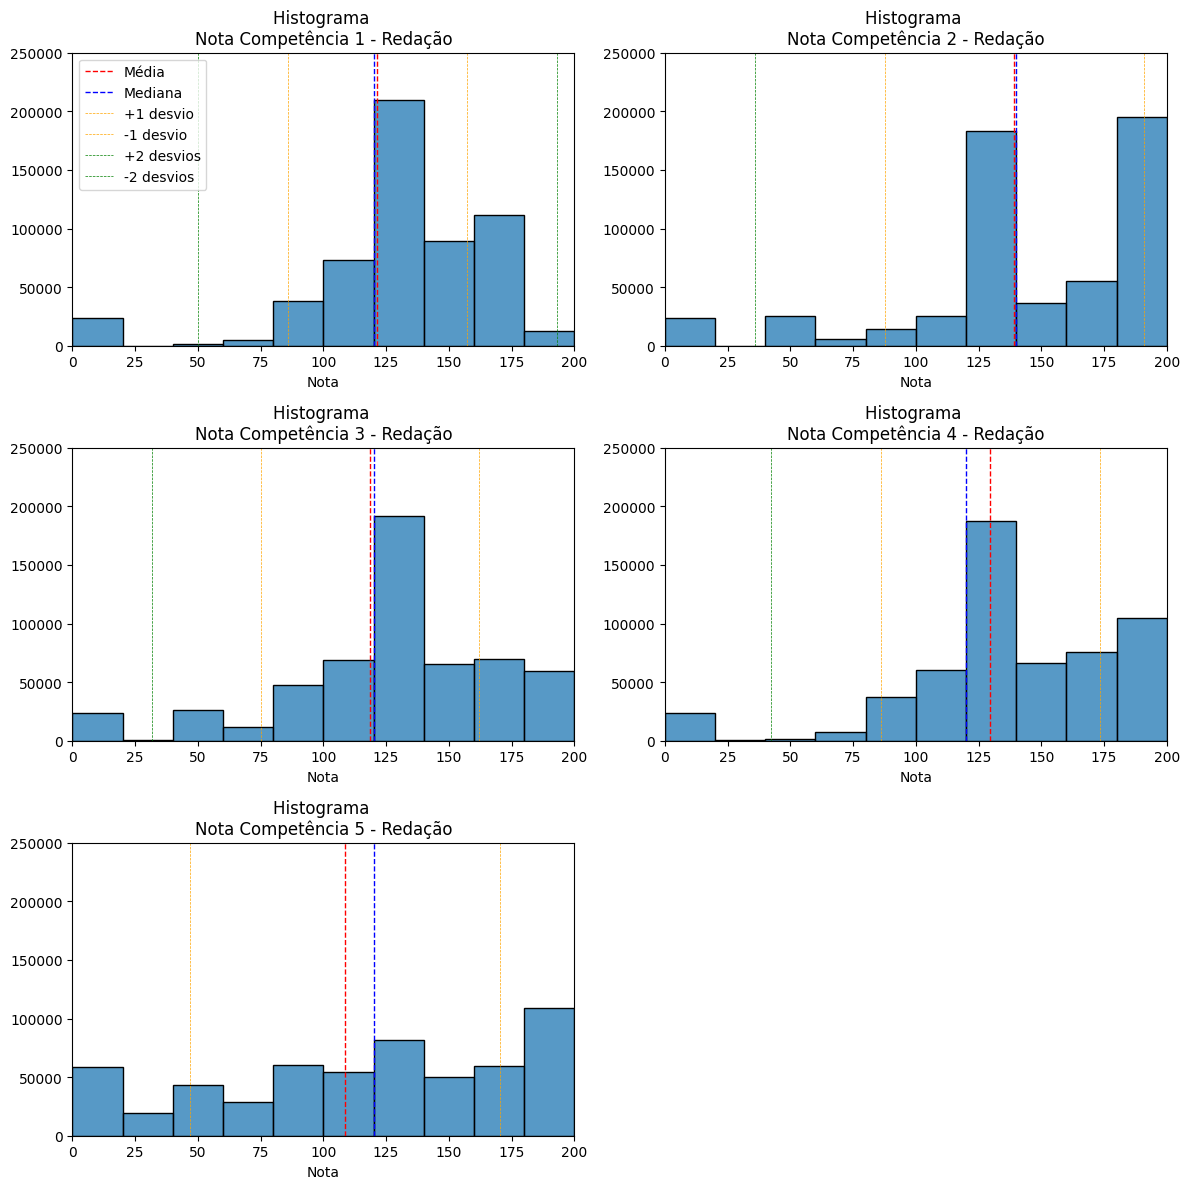

In [222]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
colunas = ['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']
titulos = ['Nota Competência 1 - Redação',
           'Nota Competência 2 - Redação',
           'Nota Competência 3 - Redação',
           'Nota Competência 4 - Redação',
           'Nota Competência 5 - Redação']

for ax, col, tit in zip(axes.flatten(), colunas, titulos):
    sns.histplot(df[col], bins=10, ax=ax)

    media = df[col].mean()
    std = df[col].std()
    mediana = df[col].median()

    ax.axvline(media, color='red', linestyle='--', linewidth=1.0, label='Média')
    ax.axvline(mediana, color='blue', linestyle='--', linewidth=1.0, label='Mediana')
    ax.axvline(media + std, color='orange', linestyle='--', linewidth=0.5, label='+1 desvio')
    ax.axvline(media - std, color='orange', linestyle='--', linewidth=0.5, label='-1 desvio')
    ax.axvline(media + 2*std, color='green', linestyle='--', linewidth=0.5, label='+2 desvios')
    ax.axvline(media - 2*std, color='green', linestyle='--', linewidth=0.5, label='-2 desvios')

    ax.set_title(f'Histograma \n{tit}', fontsize=12)
    ax.set_xlabel('Nota')
    ax.set_ylabel('')
    ax.set_xlim(0, 200) 
    ax.set_ylim(0, 250000)
  
    if col == colunas[0]:
        ax.legend()

# Remove o sexto subplot vazio (última célula da grade 2x3)
if len(colunas) < len(axes.flatten()):
    for ax in axes.flatten()[len(colunas):]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Transformação

Com intuito de categorizar as variáveis numéricas notas (área de conhecimento e competencia da prova de redação) foram adotadas 5 faixas: ausente, zerou, baixa, media e alta. O critério de classificação das notas em cada uma das faixas foi:  

**ausente:** valores NA do banco, que significa pessoas que não compareceram ou tiveram sua prova anulada no dia da prova da respectiva área de conhecimento.  
**zero:** valor da nota igual a 0 (zero).  
**baixa:** valor da nota inferior a media - 1 desvios-padrão.  
**media:** valor da nota entre a media - 1 desvios-padrão e media + 1 desvios-padrão.  
**alta:** valor da nota entre a media + 1 desvios-padrão e a media + 2 desvios-padrão.  
**super:** valor da nota superior a media + 2 desvios-padrão.  

Excepcionalmente, para as variáveis notas das competências da prova de redação (``NU_NOTA_COMP1``, ``NU_NOTA_COMP2``, ``NU_NOTA_COMP3``, ``NU_NOTA_COMP4``, ``NU_NOTA_COMP5``) foi utilizado critério diferente para classificar a nota na faixa muito alta, que consiste em notas iguais a 200. Similarmente, para a nota da redação ``NU_NOTA_REDACAO`` foi classificado como nota muito alta aquelas superiores a 900. Tal decisão foi tomada, pois como pode ser verificado no histograma **Nota da prova de redação** e **Nota Compentência da redação**, não existem dados acima de 2 desvios-padrão.  

Com a transformação dos dados numéricos, a codificação das colunas ``NU_NOTA_CN``, ``NU_NOTA_CH``, ``NU_NOTA_LC``, ``NU_NOTA_MT``, ``NU_NOTA_REDACAO``, ``NU_NOTA_COMP1``, ``NU_NOTA_COMP2``, ``NU_NOTA_COMP3``, ``NU_NOTA_COMP4``, ``NU_NOTA_COMP5`` foi:  

- 0: Faltou à prova  
- 1: zero  
- 2: baixa  
- 3: media  
- 4: alta  
- 5: super  

In [244]:
# Transformacao das variaveis numericas em categoricas, segunda as faixas estipuladas

colunas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',  'NU_NOTA_REDACAO',
           'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

for col in colunas:
    media = df[col].mean()
    std = df[col].std()

    if col not in ['NU_NOTA_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']:
        condicoes = [
            df[col].isna(),
            df[col] == 0,
            df[col] < media - std,
            df[col] <= media + std,
            df[col] <= media + 2*std,
            df[col] > media + 2*std
        ]
    elif col == 'NU_NOTA_REDACAO': 
        condicoes = [
            df[col].isna(),
            df[col] == 0,
            df[col] < media - std,
            df[col] <= media + std,
            (df[col] > media + std) & (df[col] < 900),
            df[col] >= 900
        ]
    else:
        condicoes = [
            df[col].isna(),
            df[col] == 0,
            df[col] < media - std,
            df[col] <= media + std,
            (df[col] > media + std) & (df[col] < 200),
            df[col] == 200
        ]

    valores = [0, 1, 2, 3, 4, 5]

    df[col] =  np.select(condicoes, valores)
    df[col] = df[col].astype('category')

In [ ]:
# Proporcao das faixas das notas

print("\n:")

colunas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO',
           'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']
contagens = {}
percentual = {}

for col in colunas:
    
    contagens[f'tp_{col}'] = df[col].value_counts(dropna=False)
    percentual[f'tp_{col}_pct'] = df[col].value_counts(normalize=True, dropna=False) * 100

    resultado = pd.DataFrame({
        'Frequência': contagens[f'tp_{col}'],
        'Percentual (%)': percentual[f'tp_{col}_pct'].round(2)
    })
    
    print(resultado, '\n')

## Conferência das transformações

No intuito de conferir se as transformações do banco de dados foram feitoas corretamente, ou seja, para todas as variáveis selecionadas no dataframe, precisam estar como categóricas e rotuladas com números.

In [ ]:
for col in df.select_dtypes(include='category').columns:
    valores = df[col].unique().tolist()
    try:
        # Tenta converter para número e ordenar
        valores_ordenados = sorted(valores, key=lambda x: float(x))
    except ValueError:
        # Se não forem numéricos, mantém a ordem original
        valores_ordenados = valores
    print(f'\n{col}: {valores_ordenados}')

df.info()

In [245]:
df_binario = pd.get_dummies(df, prefix_sep='_', dtype=bool)

In [246]:
nomes_colunas = df_binario.columns.tolist()
print(nomes_colunas)

['TP_SEXO_F', 'TP_SEXO_M', 'TP_ESTADO_CIVIL_0', 'TP_ESTADO_CIVIL_1', 'TP_ESTADO_CIVIL_2', 'TP_ESTADO_CIVIL_3', 'TP_ESTADO_CIVIL_4', 'TP_COR_RACA_0', 'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5', 'TP_NACIONALIDADE_0', 'TP_NACIONALIDADE_1', 'TP_NACIONALIDADE_2', 'TP_NACIONALIDADE_3', 'TP_NACIONALIDADE_4', 'TP_ESCOLA_1', 'TP_ESCOLA_2', 'TP_ESCOLA_3', 'IN_TREINEIRO_0', 'IN_TREINEIRO_1', 'TP_PRESENCA_DIA2_0', 'TP_PRESENCA_DIA2_1', 'TP_PRESENCA_DIA2_2', 'TP_PRESENCA_DIA1_0', 'TP_PRESENCA_DIA1_1', 'TP_PRESENCA_DIA1_2', 'NU_NOTA_CN_0', 'NU_NOTA_CN_1', 'NU_NOTA_CN_2', 'NU_NOTA_CN_3', 'NU_NOTA_CN_4', 'NU_NOTA_CN_5', 'NU_NOTA_CH_0', 'NU_NOTA_CH_1', 'NU_NOTA_CH_2', 'NU_NOTA_CH_3', 'NU_NOTA_CH_4', 'NU_NOTA_CH_5', 'NU_NOTA_LC_0', 'NU_NOTA_LC_1', 'NU_NOTA_LC_2', 'NU_NOTA_LC_3', 'NU_NOTA_LC_4', 'NU_NOTA_LC_5', 'NU_NOTA_MT_0', 'NU_NOTA_MT_1', 'NU_NOTA_MT_2', 'NU_NOTA_MT_3', 'NU_NOTA_MT_4', 'NU_NOTA_MT_5', 'TP_LINGUA_0', 'TP_LINGUA_1', 'TP_STATUS_REDACAO_1', 'TP_ST

## Notas sobre o uso da LLM

- A LLM foi usada para executar construir o código da amostragem otimizada em memória do arquivo de microdados do ENEM. O algoritmo gerado para selecionar e amostrar os dados foi bastante satisfatório, a não ser por um pequeno erro lógico no final: na fase ``# junta tudo``, o código tenta tirar novamente 800_000 amostras de uma lista que já tem (teoricamente) 800_000 amostras, então essa amostragem não faz sentido. Na prática, ainda, o código provavelmente vai gerar um erro, já que nosso banco não tem exatamente 4M registros e o resultado terá um pouco menos que 800k amostras.
- No momento da análise exploratória de dados, foi muito satisfatória ao sugerir gráficos que seriam mais adequados aos dados, mas o código gerado trazia muitos detalhes no gráfico que dificultavam a visualização dos dados. Por isso, foi preciso fazer uma limpeza após o código gerado.
- Para gerar dicionários das variáveis categóricas, a LLM foi extremamente útil, pois poupou um trabalho manual que demandaria tempo.

Na análise das variáveis numéricas a LLM apresentou um desempenho satisfatório. Foi capaz de construir histogramas adequados, distribuindo de forma coerente os valores das notas das provas em faixas representativas. No entanto, a definição das faixas com base na quantidade de desvios-padrão, bem como a criação das categorias específicas para notas ausentes e notas zeradas foram decisões tomadas pelo analista.

Embora o código de geração de histogramas sugerido pela LLM tenha servido como base, aspectos mais específicos — como a definição dos limites dos eixos x e y e a separação da nota de redação em um gráfico distinto — não puderam ser antecipados, uma vez que a LLM não possuía acesso aos dados. Sua sugestão de elaborar o histograma foi fornecida de forma genérica e, portanto, tais ajustes também foram realizados pelo analista.

Em especial, a LLM foi extremamente útil para um DOS integrante da dupla que não é usuário da linguagem Python. Então toda a intalação e adequação do ambiente (env, requirements.txt, Jupyter) e construção do código foram feitas com a ajuda da LLM.

https://chatgpt.com/share/6812da0f-2b38-8013-abc6-01dc19621ab7

https://chatgpt.com/share/68154c77-01d8-8005-9bbb-37c25889c447